In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim

from itertools import product

# Always make it pretty.
plt.style.use('ggplot')

import samplers as spl

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Review: Fundamental Concepts

### Random Variables, Again.

Recall that a *random variable* $X$ is an object that can be used to generate numbers, in a way that valid probabilistic statements about the generated numbers can be made.  For example:

$$ P(X > 0) = 0.5 $$
$$ P(-1 < X < 1) = 0.25 $$
$$ P(X < 0) = 0 $$
$$ P(X > 1 \mid X > 0) = 0.5 $$

are all probabilistic statements about an unknown random variable.

From a programming perspective, a random variable is a type of object that implements a single public function: `sample`.

In [2]:
class RandomVariable:
    
    def __init__(self, parameters):
        self._parameters = parameters
        
    def sample(self):
        '''Return a random sample from the variable.'''
        return algorithm_for_sampling_from_this_variable()

### Distribution and Density Functions

One very general probabilistic statement we can make about a random variable is to compute the *function*

$$ F_X(t) = P(X \leq t) $$

this is called the *cumulative density* or *distribution* function.  In a sense we could make precise, it says everything we can hope to say about the random variable.

If the distribution function is differentiable, then it's derivative is called the *probability density function*. 

$$ f_X(t) = F_X'(t) $$

The density function satisfies the following property

$$ P(t_0 < X \leq t_1) = \int_{t_0}^{t_1} f(t) dt $$

### Identically Distributed

If two random variables have the *same* distribution function, we say they are *identically distributed*, and we denote this relationship

$$ X \sim Y $$

In practice this means **any probabilistic statements we make about $X$ and $Y$ have the same answer**.

# Sampling Theory

In this section we will take another path towards understanding samples taken from an unknown population.  In the morning we fit statistical models to approximate the popuation, this afternoon we will study mathematical properties of the population itself.

## Sampling Distributions of Statistics

We need a way to mathematically model a simple random sample. For example, each of the following can be modeled as taking an i.i.d. random sample from a population:

  - A random survey of humans is an i.i.d sample of all humans of interest to the survey designers.
  - A dataset of all the quotes received for an insurance product is an i.i.d sample of all possible customers of the insurance company.
  - Driving around a city and turning a random direction at each intersection is an i.i.d sample of all possible paths driven through the city (as long as you start in a random place).
  
When we have such a situation, we will adopt a slight change in perspective that will make our mathematics work out more easily:

**We consider each individual data point drawn from our population as the outcome from its own random variable.**

So, under this model, a i.i.d sample can be thought of as a **sequence of random variables that are independent and identically distributed**

$$ X_1, X_2, X_3, \ldots, X_n $$

When we actually **physically take** the sample, i.e. **collect data**, we get datapoints $x_1, x_2, \ldots, x_n$, each one drawn from the corresponding random varaible $X_k$.
  
A **statistic** is a function of a random sample $T(X_1, X_2, ..., X_n)$.  I.e., something we can compute once we have a random sample.  Drawing different random samples will result in different values of the statistic.

### Examples of Statistics

Here are a couple simple and common statistics.  To illustrate, we've drawn 20 samples from a normal distribution and recorded the value of the statistic.

The **sample mean** is a statistic defined by $\frac{1}{n} \sum_i X_i$

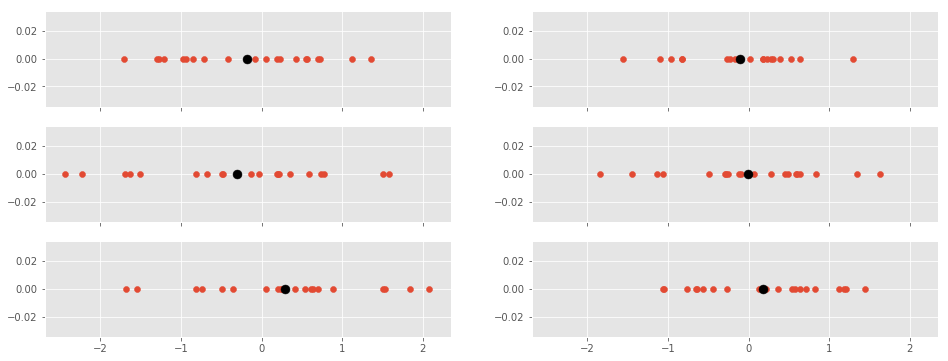

In [3]:
normal = spl.Normal(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(16, 6), sharex=True)

for ax in axs.flatten():
    samp = normal.sample(20)
    ax.scatter(samp, np.repeat(0, 20))
    mean = np.mean(samp)
    ax.scatter([mean], 0, c="black", s=80)

The **sample maximum** is defined by $\max (X_1, X_2, \ldots, X_n)$

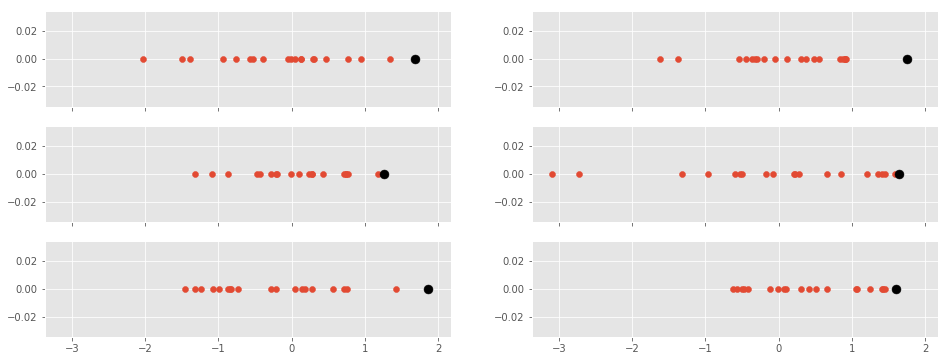

In [4]:
normal = spl.Normal(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(16, 6), sharex=True)

for ax in axs.flatten():
    samp = normal.sample(20)
    ax.scatter(samp, np.repeat(0, 20))
    M = np.max(samp)
    ax.scatter([M], 0, c="black", s=80)

**Question:** What is another sample statistic that is commonly encountered?

**Question:** Explain in your own words why sample statistics are random varaibles.  Give an example of an interesting probability involving a sample statistic.

## The Main Question In Sampling Theory

#### How do we **quantify** the amount of variation of a sample statistic?

To quantify the amount of variation of a statistic, we would really like a process like this:

  - Draw some number of independent and identically distributed data from the population $X$, i.e. a sample.
  - Compute the statistic using the sample you drew.
  - Record the value of the statistic just computed in a database.
  - Do it again, and again, and again, until the sun burns out.
  
After this process is complete, we have many examples of our statistic, each computed from a different random sample from our variable.

The distribution of *the statistic* that arises from this process is called the **sampling distribution of the statistic**.

### Example: Sample Means from A Normal Variable

Recall our sample means from the previous example:

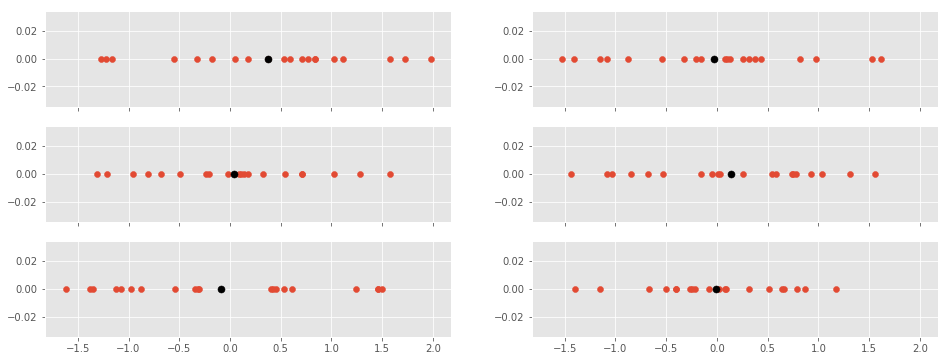

In [5]:
normal = spl.Normal(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(16, 6), sharex=True)

means = []
for ax in axs.flatten():
    samp = normal.sample(20)
    ax.scatter(samp, np.repeat(0, 20))
    mean = np.mean(samp)
    means.append(mean)
    ax.scatter([mean], 0, c="black", s=50)

The distribution of the *black points* is the **sampling distribution of the mean**.

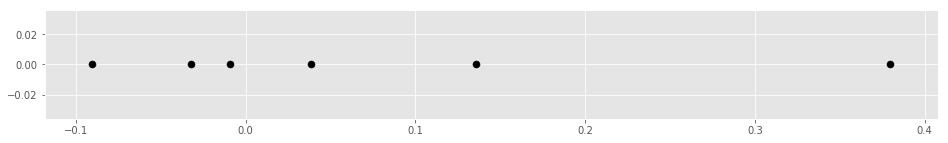

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.scatter(means, np.repeat(0, 6), c='black', s=50)

If we superimpose a sample from the original distribution, it's very clear that the spread of the sampling distribution is much smaller than that of the original.

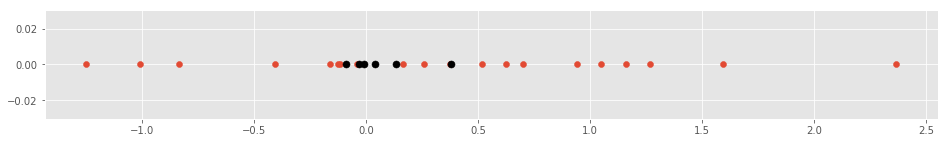

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.scatter(normal.sample(20), np.repeat(0, 20))
ax.scatter(means, np.repeat(0, 6), c='black', s=50)

Two questions present themselves:

  - What is the average value of the statistic?
  - How much does the statistic vary around its average value?

## The Law of Large Numbers

Let's focus on the simplest and possibly the most natural statistic: the *mean* of a random sample.  To be clear:

  - The **mean**, or **expectation** of a random variable or population is the theoretical quantity computed by the following integral:
  
$$ E[X] = \int_{- \infty}^{\infty} t \
f_{X}(t) dt $$

The expectation is a property of a random variable, and you *must* know the distribution of the variable *completely* to compute it.  **This *never* happens in real life**, the application of computing a mean of a random variable in this way is when we hypothesize *models* of our data, we'll get to that.

  - The **sample mean** of a set of *data* (which is often postulated to result from an i.i.d sample from a random variable) is the *practical* quantity computed as the following sum:
  
$$\frac{1}{n} \sum_i X_i$$

When both concepts are relevant, we often qualify the first from the second by using the term **population mean**.

**Note:** While the names betray a connection, it's important to realize that these two concepts are just *definitions*, subject to our whim.

The fundamental connection between the two concepts is given by the *law of large numbers*.

### The Law of Large Numbers.

Suppose that $X_1, X_2, \ldots$ are i.i.d copies of a random variable $X$, that is, a random sample from a population.  

Then, for $n$ sufficiently large, the sample mean computed from a sample of size $n$ is approximately equal to the population mean:

$$ \frac{1}{n} \sum_i X_i \approx E[X] $$

**Technical Note:** The precise mathematical statement of the law of large numbers needs some more technology, namely **[convergence in probability](https://en.wikipedia.org/wiki/Convergence_of_random_variables#Convergence_in_probability)**.  It essentially says that, as $n$ get large, the probability of seeing a sample mean that is different from the population mean goes to zero.

### Example:  Binomial Draws

Suppose that $X$ is a simple Bernoulli random variable, for simplicitly

$$ X \sim \text{Bernoulli}(p = 0.5) $$

In each of the plots below, we draw samples of increasing size from $X$, and compute the corresponding sample mean.  According to the law of large numbers, these paths of sample means should all limit towards the population expectation of $p = 0.5$.

In [8]:
def compute_cumlative_sample_means(sample):
    cumlative_sums = np.cumsum(sample)
    sample_sizes = np.arange(1, len(cumlative_sums) + 1)
    sample_means = cumlative_sums / sample_sizes
    return sample_sizes, sample_means

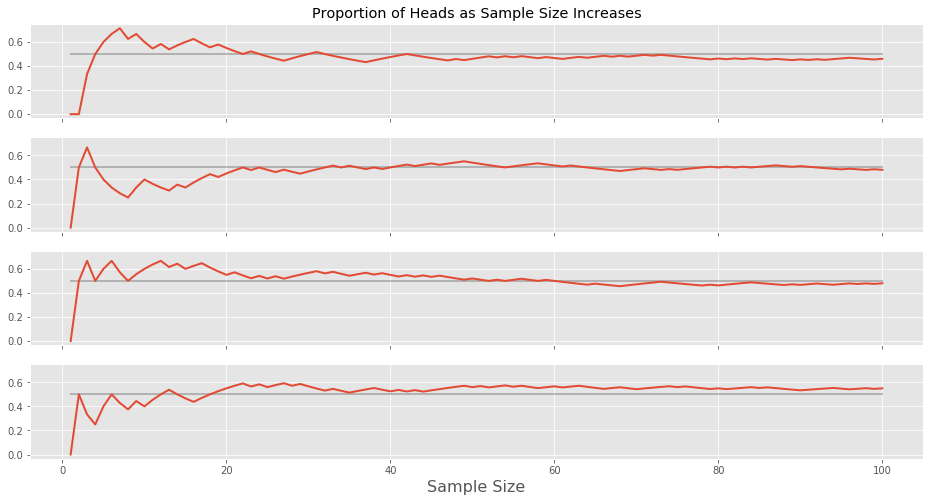

In [21]:
bernoulli = spl.Binomial(1, 0.5)

fig, axs = plt.subplots(4, 1, figsize=(16, 8), sharex=True, sharey=True)

axs[0].set_title("Proportion of Heads as Sample Size Increases")
for idx, ax in enumerate(axs.flatten()):
    sample = bernoulli.sample(100).astype(np.float64)
    sample_sizes, sample_means = compute_cumlative_sample_means(sample)
    ax.plot(sample_sizes, np.repeat(0.5, len(sample_sizes)), linewidth=2, c='grey', alpha=0.5)
    ax.plot(sample_sizes, sample_means)
    if idx == 3:
        ax.set_xlabel("Sample Size", fontsize=16)

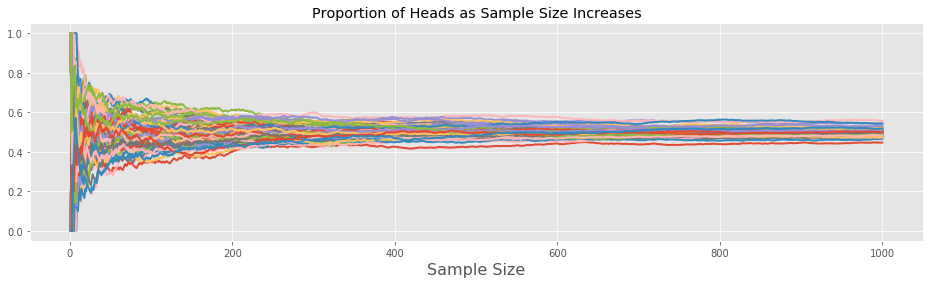

In [20]:
bernoulli = spl.Binomial(1, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True, sharey=True)

ax.set_title("Proportion of Heads as Sample Size Increases")
for i in range(100):
    sample = bernoulli.sample(1000).astype(np.float64)
    sample_sizes, sample_means = compute_cumlative_sample_means(sample)
    ax.plot(sample_sizes, sample_means)
    ax.set_xlabel("Sample Size", fontsize=16)

### A Thing that is NOT True

The law of large numbers does **not** say that the number of $0$'s sampled becomes equal to the number of $1$'s sampled as $n$ grows, **only that the differences between them are swamped out as the denominator gets large**.

If you flip a coin an infinite number of times, you should *not* expect to get "the same number of heads as tails".  Statistics does *not* say they cancel out.  Only that the differences become less noticeable over time with respect to the magnitude of numbers involved.

In [11]:
def compute_cumlative_sample_differences(sample):
    ones_and_negative_ones = sample + (sample - 1)
    cumlative_sums = np.cumsum(ones_and_negative_ones)
    sample_sizes = np.arange(1, len(cumlative_sums) + 1)
    return sample_sizes, cumlative_sums

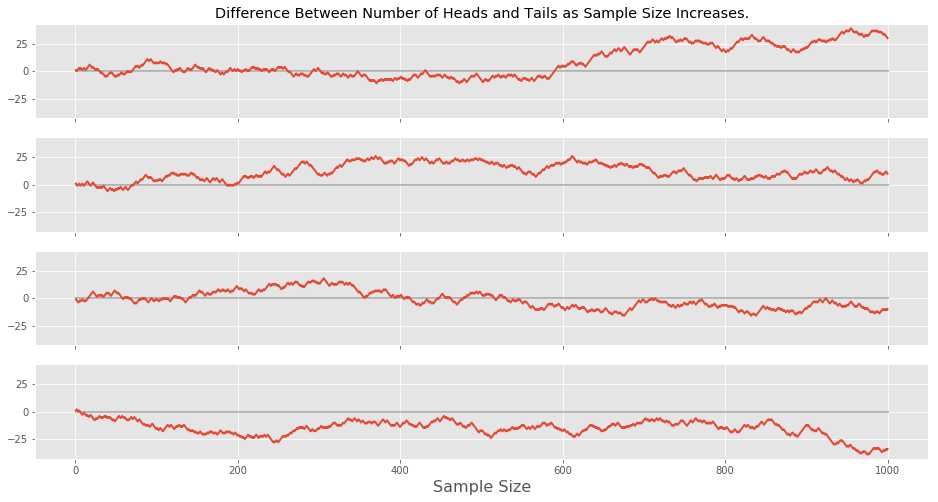

In [22]:
bernoulli = spl.Binomial(1, 0.5)

fig, axs = plt.subplots(4, 1, figsize=(16, 8), sharex=True, sharey=True)

axs[0].set_title("Difference Between Number of Heads and Tails as Sample Size Increases.")
for idx, ax in enumerate(axs.flatten()):
    sample = bernoulli.sample(1000).astype(np.float64)
    sample_sizes, sample_differences = compute_cumlative_sample_differences(sample)
    ax.plot(sample_sizes, np.repeat(0, len(sample_sizes)), linewidth=2, c='grey', alpha=0.5)
    ax.plot(sample_sizes, sample_differences)
    if idx == 3:
        ax.set_xlabel("Sample Size", fontsize=16)

In fact, if you plot many of these curves on one graph, you can see that in aggregate, they spread out over time

Text(0.5,0,'Sample Size')

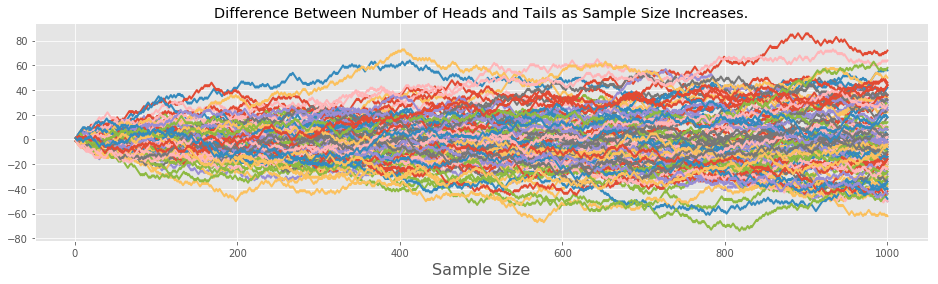

In [24]:
bernoulli = spl.Binomial(1, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True, sharey=True)

ax.set_title("Difference Between Number of Heads and Tails as Sample Size Increases.")
for i in range(100):
    sample = bernoulli.sample(1000).astype(np.float64)
    sample_sizes, sample_differences = compute_cumlative_sample_differences(sample)
    #ax.plot(sample_sizes, np.repeat(0, len(sample_sizes)), linewidth=2, c='grey', alpha=0.5)
    ax.plot(sample_sizes, sample_differences)
ax.set_xlabel("Sample Size", fontsize=16)

One way to interpret the law of large numbers is that the difference in the number of heads and tails are spreading out *slower* than that rate of increase of sample size.

## The Variance of the Sample Mean

The law of large numbers tells us that the sample mean is an estimate of the population mean.  A follow up question now arises: **how accurate of an estimate of the population mean is the sample mean?**

This is essentially asking: how tight is the bundle of curves here:

Text(0.5,0,'Sample Size')

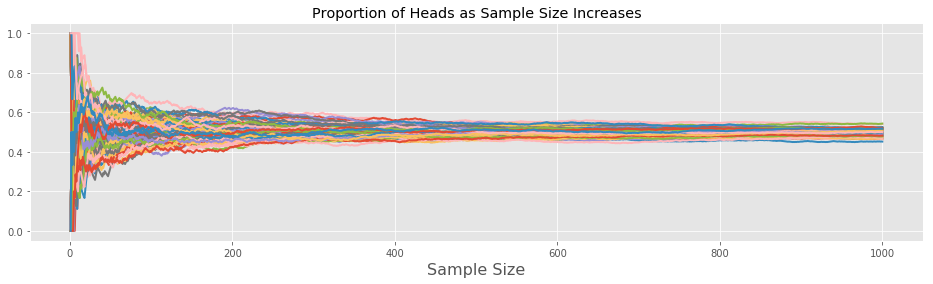

In [25]:
bernoulli = spl.Binomial(1, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True, sharey=True)

ax.set_title("Proportion of Heads as Sample Size Increases")
for i in range(100):
    sample = bernoulli.sample(1000).astype(np.float64)
    sample_sizes, sample_means = compute_cumlative_sample_means(sample)
    ax.plot(sample_sizes, sample_means)
ax.set_xlabel("Sample Size", fontsize=16)

This bundle has a characteristic shape:

Text(0.5,0,'Sample Size')

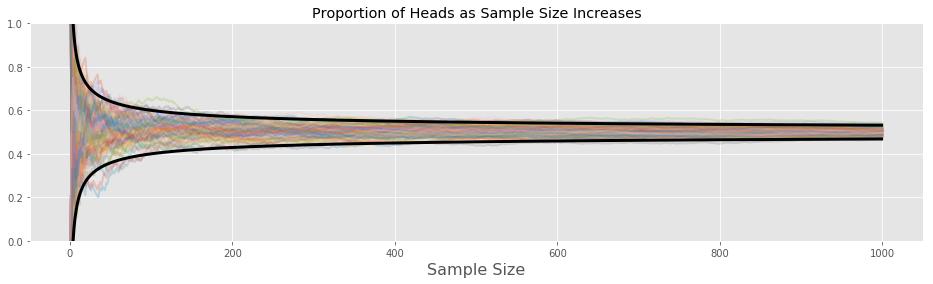

In [26]:
bernoulli = spl.Binomial(1, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True, sharey=True)

ax.set_title("Proportion of Heads as Sample Size Increases")
for i in range(100):
    sample = bernoulli.sample(1000).astype(np.float64)
    sample_sizes, sample_means = compute_cumlative_sample_means(sample)
    ax.plot(sample_sizes, sample_means, alpha=0.25) 
    
x = np.arange(1, 1000)
ax.plot(x, 0.5 + 1/np.sqrt(x), color="black", linewidth=3)
ax.plot(x, 0.5 - 1/np.sqrt(x), color="black", linewidth=3)
ax.set_ylim(0, 1.0)
ax.set_xlabel("Sample Size", fontsize=16)

Recall our observations that 
  - A sample mean has less variance than the individual draws in the samples themselves.
  - The variance of a sample mean gets smaller as the size of the sample increases.
  
It's actually possible to quantify how much less variance.

This calcualtion is a classic, and is something every statistician should be able to repeat.

$$ var \left( \frac{X_1 + X_2 + \cdots + X_n}{n} \right) = \frac{1}{n^2} var (X_1 + X_2 + \cdots + X_n) = \frac{n}{n^2} var(X) = \frac{1}{n} var (X) $$

$$ sd \left( \frac{X_1 + X_2 + \cdots + X_n}{n} \right) = \frac{1}{\sqrt{n}} sd (X) $$


The final quantity here is called the **standard error**, it is shorthand for the more unwieldy phrase **standard deviation of the sample mean**.

**Question:** There are two assumptions needed for this calculation to work out:

1. The draws are all identically distributed.
2. The draws are all independent.

Where in the calculation above have we used these facts?